In [ ]:
from pathlib import Path
import zipfile, shutil, random, re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT = Path.cwd().parent if Path.cwd().name == "notebook" else Path.cwd()
DATA = ROOT / "data"
MODELS = ROOT / "models"
MODELS.mkdir(parents=True, exist_ok=True)

TRAIN_ZIP = DATA / "train.zip"
TEST_ZIP  = DATA / "test1.zip" 


In [2]:
EXTRACT_TRAIN = DATA / "train"
if TRAIN_ZIP.exists():
    print(f"Descomprimiendo {TRAIN_ZIP.name}…")
    with zipfile.ZipFile(TRAIN_ZIP, "r") as zf:
        zf.extractall(EXTRACT_TRAIN)
    print("OK ->", EXTRACT_TRAIN)
else:
    print("⚠ No se encontró", TRAIN_ZIP)

if TEST_ZIP.exists():
    print(f"Descomprimiendo {TEST_ZIP.name}…")
    with zipfile.ZipFile(TEST_ZIP, "r") as zf:
        zf.extractall(DATA / "test")
    print("OK ->", DATA / "test")


Descomprimiendo train.zip…
OK -> c:\Users\LENOVO\OneDrive\Escritorio\UNI\proyectos\project-MLOps\MLOps-Workshop\submissions\dog_vs_cat\alexanderchavez\data\train
Descomprimiendo test1.zip…
OK -> c:\Users\LENOVO\OneDrive\Escritorio\UNI\proyectos\project-MLOps\MLOps-Workshop\submissions\dog_vs_cat\alexanderchavez\data\test


In [3]:
candidates = [
    DATA / "train_train",
    DATA / "train" / "train",
    DATA / "train",
]
TRAIN_SRC = None
for c in candidates:
    if c.exists() and any(c.glob("*.jpg")):
        TRAIN_SRC = c
        break
assert TRAIN_SRC is not None, "No encuentro carpeta con .jpg (train_train / train/train / train)."
print("SRC_TRAIN:", TRAIN_SRC)


SRC_TRAIN: c:\Users\LENOVO\OneDrive\Escritorio\UNI\proyectos\project-MLOps\MLOps-Workshop\submissions\dog_vs_cat\alexanderchavez\data\train\train


In [4]:
TRAIN_SORTED = DATA / "train_sorted"
CATS_DIR = TRAIN_SORTED / "cats"
DOGS_DIR = TRAIN_SORTED / "dogs"
for d in (CATS_DIR, DOGS_DIR): d.mkdir(parents=True, exist_ok=True)

pat_cat = re.compile(r'^cat\.\d+\.jpg$', re.IGNORECASE)
pat_dog = re.compile(r'^dog\.\d+\.jpg$', re.IGNORECASE)

moved_cats = moved_dogs = skipped = 0
for img in TRAIN_SRC.glob("*.jpg"):
    n = img.name
    if pat_cat.match(n):
        shutil.move(str(img), str(CATS_DIR / n)); moved_cats += 1
    elif pat_dog.match(n):
        shutil.move(str(img), str(DOGS_DIR / n)); moved_dogs += 1
    else:
        skipped += 1

print(f"Movidos -> cats={moved_cats}, dogs={moved_dogs}, ignorados={skipped}")
print("Destino:", TRAIN_SORTED)


Movidos -> cats=12500, dogs=12500, ignorados=0
Destino: c:\Users\LENOVO\OneDrive\Escritorio\UNI\proyectos\project-MLOps\MLOps-Workshop\submissions\dog_vs_cat\alexanderchavez\data\train_sorted


In [ ]:
VAL_SORTED = DATA / "val_sorted"
VAL_CATS, VAL_DOGS = VAL_SORTED / "cats", VAL_SORTED / "dogs"
for d in (VAL_CATS, VAL_DOGS): d.mkdir(parents=True, exist_ok=True)

def move_split(src, dst, frac=0.2, seed=1337):
    files = [p for p in src.glob("*.jpg")]
    random.Random(seed).shuffle(files)
    k = int(len(files) * frac)
    for p in files[:k]:
        shutil.move(str(p), str(dst / p.name))
    return k, len(files) - k

kc, rc = move_split(CATS_DIR, VAL_CATS)
kd, rd = move_split(DOGS_DIR, VAL_DOGS)
print(f"VAL movidas: cats={kc}, dogs={kd} · TRAIN remanente: cats={rc}, dogs={rd}")


VAL movidas: cats=2500, dogs=2500 · TRAIN remanente: cats=10000, dogs=10000


In [8]:
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 1337

_train = keras.utils.image_dataset_from_directory(
    TRAIN_SORTED, labels="inferred", label_mode="int",
    image_size=IMG_SIZE, batch_size=BATCH, seed=SEED, shuffle=True,
)
_val = keras.utils.image_dataset_from_directory(
    VAL_SORTED, labels="inferred", label_mode="int",
    image_size=IMG_SIZE, batch_size=BATCH, seed=SEED, shuffle=False,
)

class_names = tuple(_train.class_names)  # ('cats','dogs')
print("Clases:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = _train.cache().prefetch(AUTOTUNE)
val_ds   = _val.cache().prefetch(AUTOTUNE)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Clases: ('cats', 'dogs')


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# --- Modelo sencillo con backbone preentrenado ---
base = keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet"
)
base.trainable = False  # rápido y estable

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
], name="augment")

inp = keras.Input(shape=(*IMG_SIZE, 3))
x = data_aug(inp)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)                    # un poco de regularización
out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# --- Callbacks simples para parar a tiempo ---
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True
)

# Entrenamiento corto pero suficiente
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,             # 3 suele bastar; 5 da un pelín más de margen
    callbacks=[early],
    verbose=1
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 249s 390ms/step - accuracy: 0.9729 - loss: 0.0784 - val_accuracy: 0.9872 - val_loss: 0.0377
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 245s 392ms/step - accuracy: 0.9857 - loss: 0.0415 - val_accuracy: 0.9882 - val_loss: 0.0343
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.9861 - loss: 0.0372 - val_accuracy: 0.9890 - val_loss: 0.0330
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.9856 - loss: 0.0382 - val_accuracy: 0.9894 - val_loss: 0.0341
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 375ms/step - accuracy: 0.9871 - loss: 0.0365 - val_accuracy: 0.9886 - val_loss: 0.0330


In [11]:
from pathlib import Path

# Asegura rutas
ROOT = Path.cwd().parent if Path.cwd().name == "notebook" else Path.cwd()
MODELS = ROOT / "models"
MODELS.mkdir(parents=True, exist_ok=True)  # 👈 crea la carpeta si no existe

MODEL_PATH = MODELS / "cats_dogs_simple.keras"
model.save(MODEL_PATH)
print("Modelo guardado en:", MODEL_PATH)

Modelo guardado en: c:\Users\LENOVO\OneDrive\Escritorio\UNI\proyectos\project-MLOps\MLOps-Workshop\submissions\dog_vs_cat\alexanderchavez\models\cats_dogs_simple.keras


In [12]:
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras

THRESH = 0.5  # cambia a 0.55 si quieres ser más conservador

def show_and_classify(img_path: Path, th: float = THRESH):
    # carga y prepara (el modelo ya hace preprocess adentro)
    img = keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = keras.utils.img_to_array(img)[None, ...]

    # p_dog = probabilidad de "dog"
    p_dog = float(model.predict(x, verbose=0)[0, 0])
    label = "dog" if p_dog > th else "cat"

    # muestra imagen + resultado
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label}   (p_dog={p_dog:.3f})")
    plt.show()

    # imprime solo el label como pediste
    print(label)
    return label, p_dog


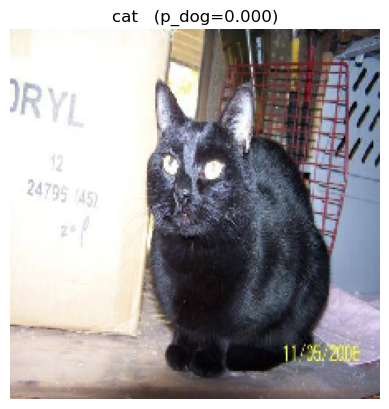

cat


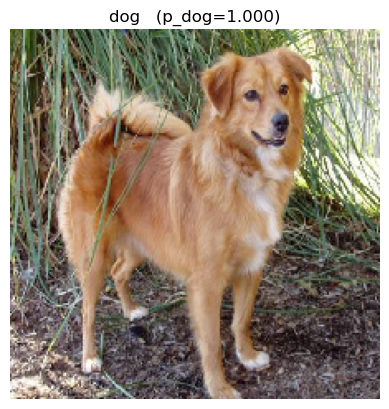

dog


('dog', 0.9999783635139465)

In [14]:
# una de cats
img1 = next((VAL_SORTED / "cats").glob("*.jpg"))
show_and_classify(img1)

# una de dogs
img2 = next((VAL_SORTED / "dogs").glob("*.jpg"))
show_and_classify(img2)
